In [126]:
pip install -r requirements.txt

     ---------------------------------------- 0.0/134.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/134.8 kB ? eta -:--:--
     --- ------------------------------------ 10.2/134.8 kB ? eta -:--:--
     ----------- ------------------------- 41.0/134.8 kB 393.8 kB/s eta 0:00:01
     -----------------------------------  133.1/134.8 kB 871.5 kB/s eta 0:00:01
     ------------------------------------ 134.8/134.8 kB 798.7 kB/s eta 0:00:00
  Using cached PyYAML-6.0.1-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached regex-2023.12.25-cp312-cp312-win_amd64.whl.metadata (41 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.0 MB/s eta 0:00:00
  Using cached Jinja2-3.1.3-py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
    --------------------------------------- 0.1/8.8 MB 4.3 MB/s eta 0:00:03
   - ----------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# Data Loading and Initial Exploration

In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(dataset_query_path, search_results_paths):
    """
    Loads and merges the query dataset with multiple search results datasets.
    
    Parameters:
    - dataset_query_path: The file path to the dataset containing the queries and the correct URLs.
    - search_results_paths: A list of file paths to the datasets containing search results.
    
    Returns:
    - A merged DataFrame containing all the data.
    """
    # Load the dataset containing queries and correct URLs
    dataset_incl_query = pd.read_csv(dataset_query_path)
    dataset_incl_query.drop(columns=['Unnamed: 0'], inplace=True)  # Drop unnecessary columns
    
    # Initialize a DataFrame to hold the merged search results
    merged_search_results = pd.DataFrame()
    
    # Load and concatenate each search results dataset
    for path in search_results_paths:
        search_results = pd.read_csv(path)
        # Optionally preprocess each search_results here (e.g., rename columns)
        # For simplicity, assuming the columns are consistently named
        if merged_search_results.empty:
            merged_search_results = search_results
        else:
            # Ensure that the DataFrame structures align before concatenating
            merged_search_results = pd.concat([merged_search_results, search_results], axis=0, ignore_index=True)
    
    # Merge the query dataset with the concatenated search results
    merged_dataset = pd.merge(dataset_incl_query, merged_search_results, on='EntityNumber', how='left')
    
    return merged_dataset

# -----------------------------------------------------------------------------------------------
# Path to the dataset containing queries and correct URLs
dataset_query_path = 'dataset_incl_query.csv'

# List of paths to the search result datasets
search_results_paths = [
    'search_results_DDG.csv'
    # Created for each search dataset seperetaly otherwise duplicates
]
merged_dataset = load_data(dataset_query_path, search_results_paths)

print(merged_dataset.head())



   EntityNumber                                       OfficialName  ZipCode  \
0  0201.310.929                                                IGL     3600   
1  0202.239.951                                           PROXIMUS     1030   
2  0203.201.340                          Nationale Bank van België     1000   
3  0206.460.639  Intergemeentelijk Samenwerkingsverband van het...     9100   
4  0206.653.946  Rijksinstituut voor Ziekte- en Invaliditeitsve...     1210   

          Municipality                Street HouseNumber  \
0                 Genk            Klotstraat         125   
1           Schaarbeek  Koning AlbertII laan          27   
2              Brussel     de Berlaimontlaan          14   
3         Sint-Niklaas             Lamstraat         113   
4  Sint-Joost-ten-Node           Galileelaan           5   

                      URL                                        SearchQuery  \
0  extranet.iglimburg.be/                                      IGL 3600 Genk   
1   

# Standerdize URLs

In [30]:
import pandas as pd
import re
from urllib.parse import urlparse

def clean_extract_domain(url, is_main_url=False):
    """
    Cleans, standardizes URLs, and extracts the domain with specific handling for the main URL column.
    
    Parameters:
    - url: The URL to be cleaned, standardized, and from which the domain will be extracted.
    - is_main_url: Flag indicating if the URL is from the main 'URL' column.
    
    Returns:
    - The domain of the cleaned and standardized URL.
    """
    if pd.isna(url):
        return url if is_main_url else None  # Keep as-is for main URL column if NaN
    
    # Ensure all URLs are strings and lowercase
    url = str(url).lower()
    
    # Standardizing starts here
    # Removing protocols and leading www.
    url = re.sub(r'^(?:http:\/\/|https:\/\/)?(?:www\.)?', '', url)
    
    # Remove all leading and trailing special characters or slashes
    url = url.strip("/").strip()
    
    # Removing trailing slash if it's not part of a protocol
    url = url.rstrip('/')
    
    # Extract the domain
    try:
        parsed_url = urlparse('http://' + url)  # Prepend scheme if missing for successful parsing
        domain = parsed_url.netloc
        # Optionally, remove 'www.' if present to standardize the format further
        domain = re.sub(r'^www\.', '', domain)
        return domain
    except Exception as e:
        print(f"Error parsing URL '{url}': {e}")
        return None if is_main_url else None  # Return None if there's an error and it's not the main URL

# Apply the function
columns_to_standardize = ['URL'] + [f'URL{i}' for i in range(1, 6)]
for col in columns_to_standardize:
    is_main_url = col == 'URL'
    merged_dataset[col] = merged_dataset[col].apply(lambda x: clean_extract_domain(x, is_main_url))


print(merged_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17239 entries, 0 to 17238
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   EntityNumber  17239 non-null  object
 1   OfficialName  17239 non-null  object
 2   ZipCode       17239 non-null  int64 
 3   Municipality  17239 non-null  object
 4   Street        17239 non-null  object
 5   HouseNumber   17239 non-null  object
 6   URL           17239 non-null  object
 7   SearchQuery   17239 non-null  object
 8   URL1          17239 non-null  object
 9   URL2          17237 non-null  object
 10  URL3          17234 non-null  object
 11  URL4          17233 non-null  object
 12  URL5          17228 non-null  object
dtypes: int64(1), object(12)
memory usage: 1.7+ MB
None


# Data preprocessing

## Tokenizer URLBert

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer(vocab_file="URLBERT-master/bert_tokenizer/vocab.txt")


## URLBert embedding

In [7]:
from transformers import AutoConfig, AutoModelForMaskedLM
import torch

# Configuration settings
config_kwargs = {
    "cache_dir": None,
    "revision": 'main',
    "use_auth_token": None,
    "hidden_dropout_prob": 0.2,
    "vocab_size": 5000,  # Adjust as per your model's vocab size
}

# Load the configuration from the specified folder
config = AutoConfig.from_pretrained("URLBERT-master/bert_config", **config_kwargs)

# Initialize the model from the loaded configuration
bert_model = AutoModelForMaskedLM.from_config(config=config)
bert_model.resize_token_embeddings(config_kwargs["vocab_size"])

# Load the pretrained model weights
bert_dict = torch.load("URLBERT-master/bert_model/urlBERT.pt", map_location='cpu')
bert_model.load_state_dict(bert_dict)

# Now your model is ready to use


<All keys matched successfully>

In [9]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the appropriate device (GPU or CPU)
bert_model.to(device)


Using device: cpu


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

### Embedding of SearchQuery and all URLs

In [65]:
!nvidia-smi
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm
# Assuming the model and tokenizer have been loaded as `model` and `tokenizer`
bert_model.eval()

def embed_text(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {k: v.to(bert_model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = bert_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Using the [CLS] token embedding
    return embeddings

# usage
search_queries = merged_dataset["SearchQuery"].tolist()
scraped_urls = [merged_dataset[f"URL{i}"].tolist() for i in range(1, 6)]

# Concatenate each URL with the corresponding search query
concatenated_texts = []
for i in range(5):
    concatenated_texts += [f"{query} [SEP] {url}" for query, url in zip(search_queries, scraped_urls[i])]



def embed_text_in_batches(texts, batch_size=10):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Batch Processing"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                           return_tensors="pt", max_length=512)
        inputs = {k: v.to(bert_model.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            # Request hidden states
            outputs = bert_model(**inputs, output_hidden_states=True)
            # Extract the last layer's hidden state
            last_hidden_state = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
            all_embeddings.append(last_hidden_state)
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return np.concatenate(all_embeddings, axis=0)


# Generate embeddings
embeddings = embed_text_in_batches(concatenated_texts, batch_size=10)




Fri Apr 12 14:18:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX150         WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   60C    P0             N/A / ERR!  |       0MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Batch Processing:   0%|          | 4/8620 [00:03<2:19:45,  1.03it/s]


KeyboardInterrupt: 

In [ ]:
print(f"Total concatenated texts to process: {len(concatenated_texts)}")

### Save to .npy file

In [ ]:
import numpy as np
np.save('./Embeddings_first_scrape/embeddings_Multi.npy', embeddings)  # Saving

### Load embeddings from .npy file

In [47]:
import numpy as np

# Load embeddings
embeddings = np.load('Embeddings_first_scrape\embeddings_DDG.npy')


<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
C:\Users\natha\AppData\Local\Temp\ipykernel_22224\3679143553.py:4: SyntaxWarning: invalid escape sequence '\e'
  embeddings = np.load('Embeddings_first_scrape\embeddings_DDG.npy')


In [61]:
# Verify the shape of the embeddings
print(f"Shape of embeddings: {embeddings.shape}")
# Assuming each embedding corresponds to one concatenated text,
# you should have as many rows in 'embeddings' as in 'concatenated_texts'


Shape of embeddings: (86195, 768)


## Prepare labels

In [49]:
import numpy as np
import pandas as pd

# Initialize a list to store the labels
labels_list = []

# Loop through each row in your dataset
for idx, row in merged_dataset.iterrows():
    official_url = row['URL']  # The true URL
    labels_for_row = []

    # Check each scraped URL against the true URL
    for i in range(1, 6):
        scraped_url = row[f'URL{i}']
        # Append 1 if the scraped URL matches the official URL, 0 otherwise
        label = 1 if scraped_url == official_url else 0
        labels_for_row.append(label)
    
    # For each dataset entry, extend labels_list with the labels for its scraped URLs
    labels_list.extend(labels_for_row)

# Convert the list of labels into a numpy array for compatibility with sklearn functions
labels_np = np.array(labels_list)

print(f"Shape of labels array: {labels_np.shape}")
# This should output a shape that matches the number of embeddings


Shape of labels array: (86195,)


In [52]:
print(f"Number of embeddings: {len(embeddings)}")
print(f"Number of label sets: {labels_np.shape[0]}")
assert embeddings.shape[0] == labels_np.shape[0], "The number of embeddings does not match the number of labels."

Number of embeddings: 86195
Number of label sets: 86195


### Split the Data into Training and Testing Sets

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embeddings, labels_np, test_size=0.2, random_state=42)



In [63]:
print(y_train.shape)
print(X_train.shape)

(68956,)
(68956, 768)


##### Scaling needed for LogReg and SVM

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now, X_train_scaled and X_test_scaled can be used for model training and predictions

# Machine learning models

#### Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
lr_model = LogisticRegression(solver='saga',max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test_scaled)


KeyboardInterrupt: 

#### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)



#### Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

# Train SVM
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)

# Make predictions
svm_predictions = svm_model.predict(X_test_scaled)



## Performance metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_predictions(y_true, y_pred, model_name):
    print(f"Evaluating {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_pred))
    print("\n")

# Evaluate Logistic Regression
evaluate_predictions(y_test, lr_predictions, "Logistic Regression")

# Evaluate Random Forest
evaluate_predictions(y_test, rf_predictions, "Random Forest Classifier")

# Evaluate SVM
evaluate_predictions(y_test, svm_predictions, "SVM")



################################################################

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, vstack
import numpy as np
import pandas as pd
from urlbert import URLBert  # Assuming this is the correct import statement

def embed_urls_with_urlbert(urls):
    # Initialize URLBert
    urlbert_model = URLBert()  # Adjust based on actual constructor, if needed
    # Embedding URLs
    embeddings = urlbert_model.embed(urls)  # Adjust method call based on actual API
    return embeddings

def preprocess_for_model(merged_dataset):
    # Assuming URLs are filled with empty string if NaN
    for i in range(1, 6):
        merged_dataset[f'URL{i}'] = merged_dataset[f'URL{i}'].fillna('')
    
    # Initialize a TF-IDF Vectorizer for SearchQuery
    query_vectorizer = TfidfVectorizer()
    query_tfidf = query_vectorizer.fit_transform(merged_dataset['SearchQuery'].fillna(''))
    features_list = [query_tfidf]
    
    # Embedding URLs using URLBert for 'URL' and 'URL1' to 'URL5'
    url_columns = ['URL'] + [f'URL{i}' for i in range(1, 6)]
    for column in url_columns:
        urls = merged_dataset[column].tolist()  # Convert column to list for embedding
        embeddings = embed_urls_with_urlbert(urls)
        # Assuming embeddings are returned as a dense array; if returned as a list or other format, you may need to convert
        features_list.append(embeddings)
    
    # Stacking all features together
    # If embeddings are numpy arrays, you'll need to convert them to sparse matrices before stacking if combining with TF-IDF vectors
    # Example conversion: sparse_embeddings = scipy.sparse.csr_matrix(embeddings)
    # Example stacking: X = hstack(features_list, format='csr')
    X = np.hstack(features_list)  # Adjust based on the actual format of embeddings
    
    # Preparing the target variable for multiclass multilabel classification
    # This needs to be tailored to your specific use case
    y = np.random.randint(2, size=(merged_dataset.shape[0], 5))  # Example placeholder
    
    return X, y



# X, y = preprocess_for_model(merged_dataset)





ModuleNotFoundError: No module named 'urlbert'

In [116]:
print(merged_dataset.head())

  (0, 7223)	0.45065828743267133
  (0, 353)	0.4530662117125485
  (0, 8529)	0.7691801582026748
  (1, 14695)	0.4769548587391425
  (1, 12)	0.47800961726650043
  (1, 13652)	0.737577703381724
  (2, 3206)	0.29004480278483813
  (2, 7)	0.3109365476769959
  (2, 2320)	0.398345666365714
  (2, 17105)	0.2827048615490225
  (2, 2077)	0.5333392051335851
  (2, 11958)	0.5441878897108008
  (3, 12145)	0.23802331794034298
  (3, 15111)	0.17913519541509676
  (3, 630)	0.2507830323517516
  (3, 17951)	0.29846251842718985
  (3, 10091)	0.3815302854961641
  (3, 8105)	0.2728591576108331
  (3, 14578)	0.43050965799891544
  (3, 8864)	0.4176839436551757
  (3, 17105)	0.42363611342550145
  (4, 12180)	0.27976480205094506
  (4, 16260)	0.2753857720497435
  (4, 9265)	0.2782567179178022
  (4, 37)	0.27976480205094506
  :	:
  (16937, 117264)	1.0
  (16943, 117264)	1.0
  (16967, 117264)	1.0
  (16999, 117264)	1.0
  (17003, 117264)	1.0
  (17007, 117264)	1.0
  (17020, 117264)	1.0
  (17035, 117264)	1.0
  (17037, 117264)	1.0
  (17052, 

In [115]:
print(merged_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17239 entries, 0 to 17238
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   EntityNumber                      17239 non-null  object
 1   OfficialName                      17239 non-null  object
 2   ZipCode                           17239 non-null  int64 
 3   Municipality                      17239 non-null  object
 4   Street                            17239 non-null  object
 5   HouseNumber                       17239 non-null  object
 6   URL                               17239 non-null  object
 7   SearchQuery                       17239 non-null  object
 8   URL1                              17239 non-null  object
 9   URL2                              17239 non-null  object
 10  URL3                              17239 non-null  object
 11  URL4                              17239 non-null  object
 12  URL5              

In [108]:
print(merged_dataset.head(20))

    EntityNumber                                       OfficialName  ZipCode  \
0   0201.310.929                                                IGL     3600   
1   0202.239.951                                           PROXIMUS     1030   
2   0203.201.340                          Nationale Bank van België     1000   
3   0206.460.639  Intergemeentelijk Samenwerkingsverband van het...     9100   
4   0206.653.946  Rijksinstituut voor Ziekte- en Invaliditeitsve...     1210   
5   0206.731.645                 Rijksdienst voor Sociale Zekerheid     1060   
6   0206.732.437   Hulpkas voor Ziekte- en Invaliditeitsverzekering     1000   
7   0206.732.536              Hulpkas voor Werkloosheidsuitkeringen     1210   
8   0206.732.932               Rijksdienst voor Jaarlijkse Vakantie     1000   
9   0206.733.229                              Nationale Arbeidsraad     1040   
10  0206.734.318           Federaal agentschap voor beroepsrisico's     1210   
11  0206.737.484                Rijksdie

# Statistics about dataframe

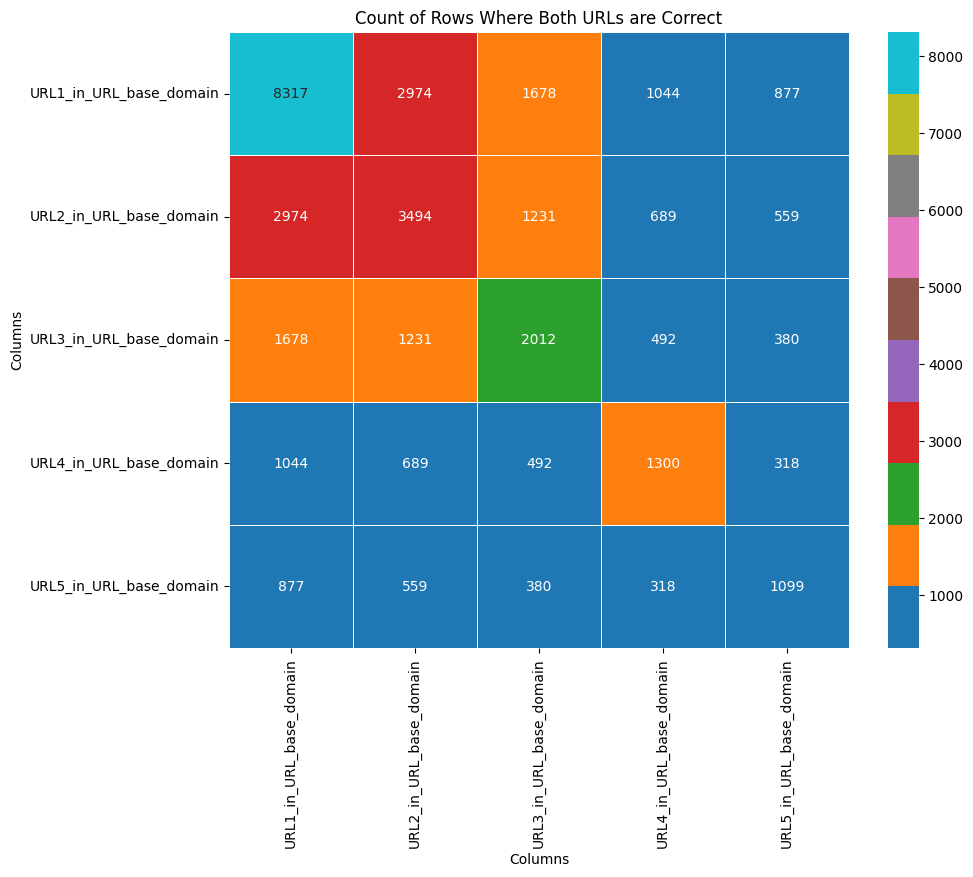

Amount of entries where none of the URLs was correct: 7981


In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_false_ratings(dataframe):
    """
    Analyzes the false ratings in the URL(i)_correct columns and calculates the count of rows
    where both URLs are correct (have a 1) for every combination of URL(i)_binary columns.

    Parameters:
    - dataframe: The DataFrame containing the URL(i)_binary columns.

    Returns:
    - A DataFrame representing the count of rows where both URLs are correct for every combination of URL(i)_binary columns.
    """
    # Columns to check for false ratings
    url_binary_cols = [f'URL{i}_in_URL_base_domain' for i in range(1, 6)]
    
    # Initialize a dictionary to store the results
    results = {}
    
    # Calculate count of rows where both URLs are correct for every combination of URL(i)_binary columns
    combination_counts = pd.DataFrame(index=url_binary_cols, columns=url_binary_cols)
    for i in range(len(url_binary_cols)):
        for j in range(i+1, len(url_binary_cols)):
            col1 = url_binary_cols[i]
            col2 = url_binary_cols[j]
            combination_counts.loc[col1, col2] = ((dataframe[col1] == 1) & (dataframe[col2] == 1)).sum()
            combination_counts.loc[col2, col1] = combination_counts.loc[col1, col2]
    
    # Store the results
    results['combination_counts'] = combination_counts
    
    # Count rows with only 0s across all five columns
    rows_with_only_zeros = (dataframe[url_binary_cols].sum(axis=1) == 0).sum()
    results['rows_with_only_zeros'] = rows_with_only_zeros
    
    # Calculate the count of 1's in each column for each URL(i)_binary column
    ones_per_column = {}
    for col in url_binary_cols:
        ones_per_column[col] = dataframe[col].sum()
    results['ones_per_column'] = ones_per_column
    
    return results

# Assuming 'merged_dataset' is your DataFrame
results = analyze_false_ratings(merged_dataset)

# Create a DataFrame for visualization
matrix = results['combination_counts']

# Convert the matrix to numeric values
matrix = matrix.apply(pd.to_numeric, errors='coerce')

# Set diagonal values to the sum of each row
for i in range(matrix.shape[0]):
    matrix.iloc[i, i] = merged_dataset[f'URL{i+1}_in_URL_base_domain'].sum()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='tab10', fmt='g', linewidths=0.5)
plt.title("Count of Rows Where Both URLs are Correct")
plt.xlabel('Columns')
plt.ylabel('Columns')
plt.show()

print(f'Amount of entries where none of the URLs was correct: {results['rows_with_only_zeros']}')

# Machine learning algorithms

# Logistic regression

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select and train a model
# Initialize the Logistic Regression model
model_LogReg = LogisticRegression(random_state=42)

# Train the model
model_LogReg.fit(X_train, y_train)

# Make predictions on the test set
predictions_LogReg = model_LogReg.predict(X_test)

# Calculate the accuracy
accuracy_LogReg = accuracy_score(y_test, predictions_LogReg)

print(f"Accuracy: {accuracy_LogReg}")


MemoryError: Unable to allocate 11.7 GiB for an array with shape (13402, 117266) and data type float64

# Lasso

In [72]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Assuming you have your features matrix X and target y
lasso = Lasso(alpha=0.1)  # alpha is the regularization strength
lasso.fit(X, y)

# You can then use lasso to make predictions
predictions_lasso = lasso.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, predictions_lasso)

# Calculate R-squared score
r2 = r2_score(y_test, predictions_lasso)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")


Mean Squared Error: 0.24996184916497075
R-squared Score: -0.0002364292448331362


## Regularization in Neural Networks

In [76]:
%pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2

model_RegNeural = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

model_RegNeural.compile(optimizer='adam', loss='binary_crossentropy')
model_RegNeural.fit(X_train, y_train, epochs=10, validation_split=0.2)
# Make predictions on the test set
predictions_RegNeural = model_RegNeural.predict(X_test)

# Calculate the accuracy
accuracy_RegNeural = accuracy_score(y_test, predictions_RegNeural)

print(f"Accuracy: {accuracy_RegNeural}")

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/377.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/377.1 MB 1.7 MB/s eta 0:03:49
   ---------------------------------------- 0.3/377.1 MB 3.0 MB/s eta 0:02:07
   ---------------------------------------- 0.5/377.1 MB 3.4 MB/s eta 0:01:52
   ---------------------------------------- 0.7/377.1 MB

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
c:\Users\natha\Anaconda3\envs\URLfinder\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


AttributeError: module 'keras.src.backend' has no attribute 'convert_to_numpy'

# Evaluation

# Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid Search for Hyperparameter Tuning with Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

#grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
#grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
#best_model = grid_search.best_estimator_

# Evaluate the best model
#predictions = best_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.544689495066744
